# Проект 7. Классификация изображений

**Цели проекта**: 
* закрепить навыки работы со сверточными нейронными сетями
* на практике опробовать достоинства и недостатки таких подходов, как `transfer learning` и `fine tuning`

**Задачи проекта**:
классифицировать модель автомобиля по его фото, используя предобученные СНС на базе фреймворков `keras` и `tensorflow`

## tl;dr

В таблице ниже собраны результаты всех моих попыток решения задачи классификации модели авто по фото:

Model | test val_accuracy % | kaggle score
:-----|---------------------|--------------
Xception целиком | 94.68 | 0.94831
Xception fine tuning | 93.26 | 0.92644
ResNet50V2 целиком | 95.66 | 0.95505
EfficientNetB7 целиком | 96.48 | **0.96764** 
EfficientNetB7 fine tuning | 83.38 | 😔
EfficientNetB7 с регуляризацией целиком | 96.39 | 0.96644
TTA на EfficientNetB7 целиком | | 0.96704
усреднение ТТА на 3 моделях | | 0.96704
голосование ТТА на 3 моделях | | 0.96704
стеккинг на 3 моделях||


Данный ноутбук запускался на моей локальной машине и на `Colab Pro`. 
Непосредственно текущая версия предназначена для использования на локальной машине.
Для удобства проверки, код для быстрого старта на `Colab` вынесен в начало и закомментирован.
Подразумевается, что у проверяющего есть файл `kaggle.json` с токеном доступа к кагглу, и он загружен в папку `/content/`

In [ ]:
# !chmod 600 kaggle.json
# !mkdir -p /root/.kaggle
# !mv kaggle.json /root/.kaggle/

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#!kaggle competitions download -c sf-dl-car-classification -p ./input/

In [ ]:
# use in Colab
#MODEL_PATH = '/content/drive/MyDrive/'

# use on local notebooks
MODEL_PATH = './'

In [1]:
!nvidia-smi

Tue Nov  9 18:27:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:2C:00.0  On |                  N/A |
| 30%   37C    P8    N/A /  75W |    314MiB /  4038MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # suppress INFO and WARNING

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

tf.get_logger().setLevel('ERROR')

In [3]:
print(os.listdir('./input'))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['test.zip', 'train.csv', 'sample-submission.csv', 'train.zip']
Python       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
Numpy        : 1.19.5
Tensorflow   : 2.6.0
Keras        : 2.6.0


In [4]:
!pip freeze > requirements.txt

Ноутбук гарантированно **не** запустится на версии `tensorflow 2.4`, на `2.5` не тестировал. Environment был подобран максимально близкий между `Colab` и локальной машиной

# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 10 # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = './input/'
PATH = "./working/car/" # рабочая директория

In [6]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH, exist_ok=True)

RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [7]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


<AxesSubplot:>

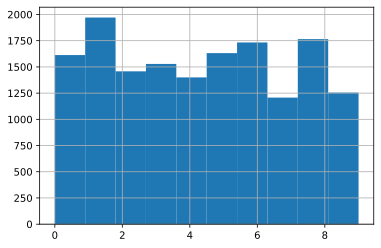

In [9]:
train_vc = train_df.Category.value_counts()
train_df.Category.hist()

Распределение более-менее равномерное, не будем делать стратификацию

In [119]:
if (len(os.listdir(PATH)) == 0):
    print('Распаковываем картинки')
    # Will unzip the files so that you can see them..
    for data_zip in ['train.zip', 'test.zip']:
        with zipfile.ZipFile('./input/' + data_zip, 'r') as z:
            z.extractall(PATH)
    
    print(os.listdir(PATH))

Пример картинок (random sample)


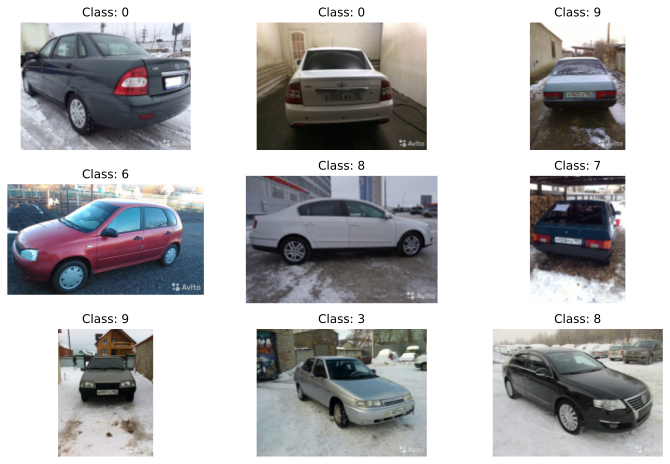

In [11]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

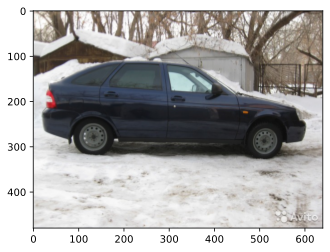

(640, 480)

In [12]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [68]:
train_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=VAL_SPLIT,
    # ниже параметры аугментаций:
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=VAL_SPLIT,
)

subm_datagen = ImageDataGenerator(
    #rescale=1/255
)

# Построение модели

Чтобы сократить объем кода в последствии, объявим класс-обертку для моделей, который будет содержать следующие методы:
* метод, который будет проводить обучение, тестирование и выводить результаты на экран. 
* метод, который будет замораживать/размораживать часть слоев модели
* метод, который будет вычислять сабмишн и сохранять его в файл для загрузки на `kaggle.com`

> **Disclaimer**
>
> Я уже понял, что данная архитектура кода неудобная, т.к. при любом изменении кода методов класса надо пересоздавать инстансы, чтобы изменения "применились". Но было уже а) поздно; б) на момент организации кода в класс он уже был практически отполирован.
> Лучше было сделать отдельно класс, хранящий модель, базовую модель, генераторы, etc, и отдельно методы, принимающие на вход инстанс этого класса.

In [20]:
class ModelSet:
    def __init__(self, base_md, rescale=True, drop_rate=None, batch_size=BATCH_SIZE):
        # create model
        self.model = Sequential()
        if rescale:
            self.model.add(InputLayer(input_shape=input_shape))
            self.model.add(Rescaling(scale=1./255))
        
        self.model.add(base_md)
        self.model.add(GlobalAveragePooling2D())
        self.model.add(Dense(512, activation='relu'))
        self.model.add(BatchNormalization())
        if drop_rate != None:
            self.model.add(Dropout(drop_rate))
            
        self.model.add(Dense(CLASS_NUM, activation='softmax'))
        # initialize other variables
        self.base_model = base_md
        self.batch_size = 0
        self.train_generator = None
        self.test_generator = None
        self.set_batch_size(batch_size)


    def set_batch_size(self, batch_size=BATCH_SIZE):
        if self.batch_size != batch_size:
            self.batch_size = batch_size
            self.train_generator = train_datagen.flow_from_directory(
                PATH+'train/',      # директория где расположены папки с картинками 
                target_size=(IMG_SIZE, IMG_SIZE),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True, 
                seed=RANDOM_SEED,
                subset='training') # set as training data

            self.test_generator = val_datagen.flow_from_directory(
                PATH+'train/',
                target_size=(IMG_SIZE, IMG_SIZE),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True,
                seed=RANDOM_SEED,
                subset='validation') # set as validation data

        
    def compile(self, trainable_frac = None, trainable_since=None, lr=LR):
        # compute total count of frozen layers
        frozen_cnt = 0
        n_layers = len(self.base_model.layers)
        if trainable_frac != None:
            trainable = max(0., min(1., trainable_frac)) # from 0 to 100% of layers
            trainable_cnt = int(round(n_layers * trainable))
            frozen_cnt = n_layers - trainable_cnt
        elif trainable_since != None:
            frozen_cnt = min(n_layers, trainable_since)
            
        self.base_model.trainable = True
        # make first 'frozen_cnt' layers frozen
        for layer in self.base_model.layers[:frozen_cnt]:
            layer.trainable = False
        # make remaining levels trainable
        for layer in self.base_model.layers[frozen_cnt:]:
            layer.trainable = True
            
        # compile model if needed
        if lr != None:
            self.model.compile(loss="categorical_crossentropy", 
                               optimizer=optimizers.Adamax(learning_rate=lr), 
                               metrics=["accuracy"])
        # return stats abot how many variables are trainable
        return self.model.summary()


    def train_and_test(self, desc=None, n_epochs=EPOCHS, batch_size=None):
        if batch_size != None:
            self.set_batch_size(batch_size)

        # подготовка к обучению
        filename = 'best_model.hdf5' if desc == None else ('best_model_' + str(desc) + '.hdf5')
        filename = MODEL_PATH + filename
        checkpoint = ModelCheckpoint(filename, monitor = ['val_accuracy'], verbose=1, mode='max')
        #earlystop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=False)
        reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=3, mode='max')
        #callbacks_list = [checkpoint, earlystop]
        callbacks_list = [checkpoint, reduce_lr]
        # непосредственно обучение
        history = self.model.fit(
            self.train_generator,
            steps_per_epoch = len(self.train_generator),
            validation_data = self.test_generator, 
            validation_steps = len(self.test_generator),
            epochs = n_epochs,
            callbacks = callbacks_list
        )
        # сохрание итоговой сети и подгрузка лучшей итерации в обучении (best_model)
        self.model.save('./working/model_last.hdf5')
        self.model.load_weights(filename)
        # тестирование, результат и графики обучения/тестирования
        scores = self.model.evaluate(self.test_generator, steps=len(self.test_generator), verbose=1)
        print('=========================================')
        print("Test accuracy: %.2f%%" % (scores[1]*100))
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.figure()

        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()


    def make_submission(self, desc=None, batch_size=BATCH_SIZE):
        filename = 'submission.csv' if desc == None else ('submission_' + str(desc) +'.csv')
        filename = MODEL_PATH + filename
        subm_generator = subm_datagen.flow_from_dataframe(
            dataframe=sample_submission,
            directory=PATH+'test_upload/',
            x_col="Id",
            y_col=None,
            shuffle=False,
            class_mode=None,
            seed=RANDOM_SEED,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=batch_size)
        predictions = self.model.predict(subm_generator, steps=len(subm_generator), verbose=1) 
        predictions = np.argmax(predictions, axis=-1) #multiple categories
        label_map = (self.train_generator.class_indices)
        label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
        predictions = [label_map[k] for k in predictions]
        filenames_with_dir=subm_generator.filenames
        submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
        submission['Id'] = submission['Id'].replace('test_upload/','')
        submission.to_csv(filename, index=False)
        print('Save submit')
        submission.head()

    
    def load_weights(self, desc=None):
        filename = 'best_model.hdf5' if desc == None else ('best_model_' + str(desc) + '.hdf5')
        filename = MODEL_PATH + filename
        self.model.load_weights(filename)
        
        
    def clone(self):
        return clone_model(self.model)

в методе `compile` можно разморозить часть слоев базовой сети, начиная с какого-либо слоя (`trainable_since`) или сколько % начиная с конца (`trainable_frac`)

метод `train_and_test` обучает сеть в течение `n_epochs`, на каждой эпохе сохраняет лучшие веса в файл, а после обучения загружает лучшие веса и на их основе делает валидацию. на выходе метода модель гарантировано остается со своими лучшими весами

в методе `make_submisssion` заданная модель генирирует сабмишн в заданном виде и сохраняет его в файл для дальнейшей загрузки на `kaggle`

## Xception (обучение модели целиком)

In [51]:
bm_xception = Xception(weights='imagenet', include_top=False, input_tensor=None)

In [52]:
bm_xception.summary()
# Рекомендация: Попробуйте и другие архитектуры сетей

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [53]:
md_xception = ModelSet(bm_xception)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [54]:
md_xception.compile()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 21,917,746
Trainable params: 21,862,194
Non-trainable params: 55,552
_____________________________________

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Epoch 1/10
1654/1654 [==============================] - 588s 355ms/step - loss: 1.1197 - accuracy: 0.6094 - val_loss: 0.4843 - val_accuracy: 0.8218

Epoch 00001: saving model to ./best_model_xp_from_scratch.hdf5


/opt/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
1654/1654 [==============================] - 589s 356ms/step - loss: 0.4986 - accuracy: 0.8305 - val_loss: 0.3031 - val_accuracy: 0.8901

Epoch 00002: saving model to ./best_model_xp_from_scratch.hdf5
Epoch 3/10
1654/1654 [==============================] - 590s 357ms/step - loss: 0.3424 - accuracy: 0.8804 - val_loss: 0.2636 - val_accuracy: 0.9098

Epoch 00003: saving model to ./best_model_xp_from_scratch.hdf5
Epoch 4/10
1654/1654 [==============================] - 590s 357ms/step - loss: 0.2565 - accuracy: 0.9110 - val_loss: 0.2399 - val_accuracy: 0.9210

Epoch 00004: saving model to ./best_model_xp_from_scratch.hdf5
Epoch 5/10
1654/1654 [==============================] - 590s 357ms/step - loss: 0.1991 - accuracy: 0.9293 - val_loss: 0.2216 - val_accuracy: 0.9274

Epoch 00005: saving model to ./best_model_xp_from_scratch.hdf5
Epoch 6/10
1654/1654 [==============================] - 590s 357ms/step - loss: 0.1686 - accuracy: 0.9425 - val_loss: 0.2060 - val_accuracy: 0.9369

Epo

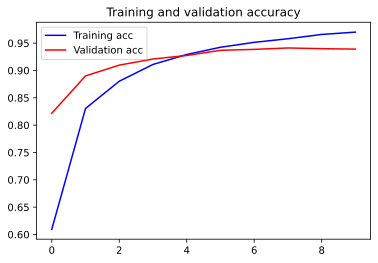

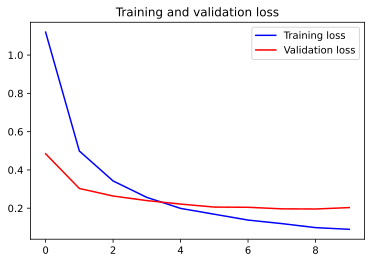

In [55]:
# do not run this code unless you want to waste an hour or more
md_xception.train_and_test(desc='xp_from_scratch', batch_size=int(BATCH_SIZE/2))

Epoch 1/5
1654/1654 [==============================] - 592s 357ms/step - loss: 0.0654 - accuracy: 0.9780 - val_loss: 0.1951 - val_accuracy: 0.9403

Epoch 00001: saving model to ./best_model_xp_from_scratch_2.hdf5


/opt/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
1654/1654 [==============================] - 591s 357ms/step - loss: 0.0620 - accuracy: 0.9774 - val_loss: 0.1905 - val_accuracy: 0.9407

Epoch 00002: saving model to ./best_model_xp_from_scratch_2.hdf5
Epoch 3/5
1654/1654 [==============================] - 592s 358ms/step - loss: 0.0600 - accuracy: 0.9807 - val_loss: 0.1912 - val_accuracy: 0.9442

Epoch 00003: saving model to ./best_model_xp_from_scratch_2.hdf5
Epoch 4/5
1654/1654 [==============================] - 593s 358ms/step - loss: 0.0630 - accuracy: 0.9799 - val_loss: 0.1878 - val_accuracy: 0.9442

Epoch 00004: saving model to ./best_model_xp_from_scratch_2.hdf5
Epoch 5/5
1654/1654 [==============================] - 592s 358ms/step - loss: 0.0580 - accuracy: 0.9814 - val_loss: 0.1889 - val_accuracy: 0.9468

Epoch 00005: saving model to ./best_model_xp_from_scratch_2.hdf5
292/292 [==============================] - 21s 73ms/step - loss: 0.1889 - accuracy: 0.9468
Test accuracy: 94.68%


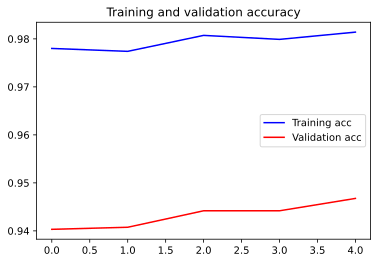

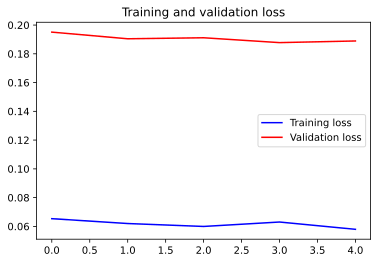

In [59]:
md_xception.train_and_test(desc='xp_from_scratch_2', n_epochs=5, batch_size=int(BATCH_SIZE/2))

Сделаем сабмишн на его основе:

In [63]:
md_xception.make_submission(desc='xp_from_scratch')

Found 6675 validated image filenames.
418/418 [==============================] - 59s 134ms/step
Save submit


Полученный **`score=0.94831`**

## Xception (fine tuning с постепенной разморозкой)

создадим сеть заново, заморозим базовую модель, и будем постепенно размораживать ее слои по мере обучения

In [120]:
bm_xception = Xception(weights='imagenet', include_top=False, input_tensor=None)
md_xception = ModelSet(bm_xception)
md_xception.compile(trainable_frac=0, lr=1e-3)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
Total params: 21,917,746
Trainab

Epoch 1/10
827/827 [==============================] - 147s 176ms/step - loss: 1.3542 - accuracy: 0.5268 - val_loss: 1.1426 - val_accuracy: 0.5857

Epoch 00001: saving model to ./best_model_xp_t0.hdf5
Epoch 2/10


/opt/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


827/827 [==============================] - 145s 176ms/step - loss: 1.0828 - accuracy: 0.6202 - val_loss: 1.0323 - val_accuracy: 0.6402

Epoch 00002: saving model to ./best_model_xp_t0.hdf5
Epoch 3/10
827/827 [==============================] - 146s 176ms/step - loss: 1.0103 - accuracy: 0.6442 - val_loss: 1.0060 - val_accuracy: 0.6342

Epoch 00003: saving model to ./best_model_xp_t0.hdf5
Epoch 4/10
827/827 [==============================] - 145s 175ms/step - loss: 0.9553 - accuracy: 0.6666 - val_loss: 0.9786 - val_accuracy: 0.6445

Epoch 00004: saving model to ./best_model_xp_t0.hdf5
Epoch 5/10
827/827 [==============================] - 145s 175ms/step - loss: 0.9159 - accuracy: 0.6772 - val_loss: 0.9720 - val_accuracy: 0.6531

Epoch 00005: saving model to ./best_model_xp_t0.hdf5
Epoch 6/10
827/827 [==============================] - 146s 176ms/step - loss: 0.8743 - accuracy: 0.6878 - val_loss: 0.9255 - val_accuracy: 0.6775

Epoch 00006: saving model to ./best_model_xp_t0.hdf5
Epoch 7/10


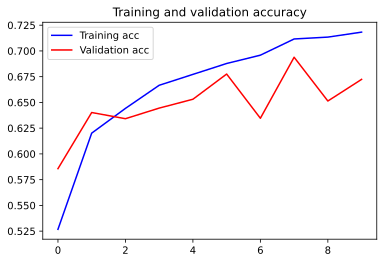

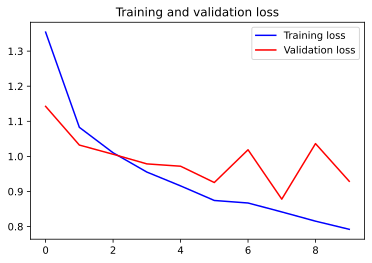

In [65]:
md_xception.train_and_test(desc='xp_t0')

In [122]:
md_xception.compile(trainable_frac=0.1, lr=1e-3)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
Total params: 21,917,746
Trainable params: 7,294,370
Non-trainable params: 14,623,376
_________________________________

Epoch 1/10
827/827 [==============================] - 157s 188ms/step - loss: 1.0050 - accuracy: 0.6453 - val_loss: 1.8336 - val_accuracy: 0.5307

Epoch 00001: saving model to ./best_model_xp_t10.hdf5


/opt/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
827/827 [==============================] - 157s 189ms/step - loss: 0.6695 - accuracy: 0.7596 - val_loss: 2.1319 - val_accuracy: 0.4727

Epoch 00002: saving model to ./best_model_xp_t10.hdf5
Epoch 3/10
827/827 [==============================] - 157s 190ms/step - loss: 0.5574 - accuracy: 0.8004 - val_loss: 5.1264 - val_accuracy: 0.3358

Epoch 00003: saving model to ./best_model_xp_t10.hdf5
Epoch 4/10
827/827 [==============================] - 158s 190ms/step - loss: 0.4727 - accuracy: 0.8313 - val_loss: 0.8453 - val_accuracy: 0.7248

Epoch 00004: saving model to ./best_model_xp_t10.hdf5
Epoch 5/10
827/827 [==============================] - 158s 190ms/step - loss: 0.3982 - accuracy: 0.8572 - val_loss: 1.2824 - val_accuracy: 0.6973

Epoch 00005: saving model to ./best_model_xp_t10.hdf5
Epoch 6/10
827/827 [==============================] - 158s 190ms/step - loss: 0.3661 - accuracy: 0.8654 - val_loss: 1.5681 - val_accuracy: 0.6127

Epoch 00006: saving model to ./best_model_xp_t10.

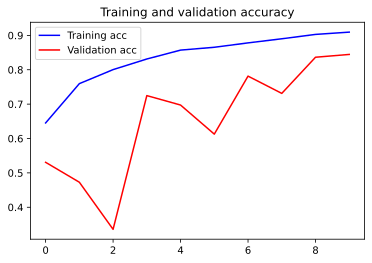

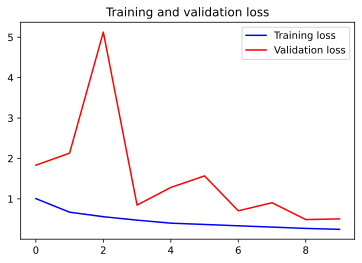

In [123]:
md_xception.train_and_test(desc='xp_t10')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
Total params: 21,917,746
Trainable params: 10,513,586
Non-trainable params: 11,404,160
________________________________

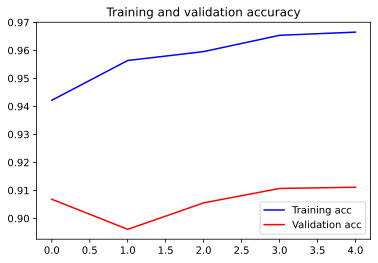

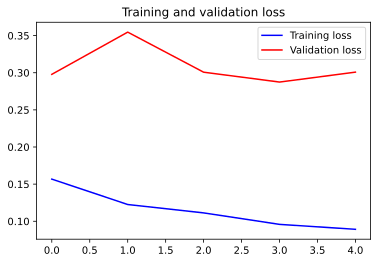

In [126]:
md_xception.compile(trainable_frac=0.25, lr=1e-4)
md_xception.train_and_test(desc='xp_t25', n_epochs=5)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
Total params: 21,917,746
Trainable params: 15,878,946
Non-trainable params: 6,038,800
_________________________________

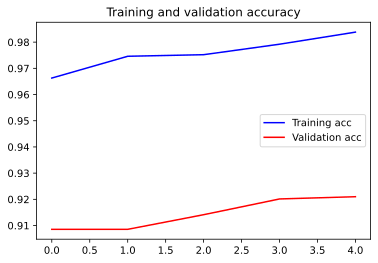

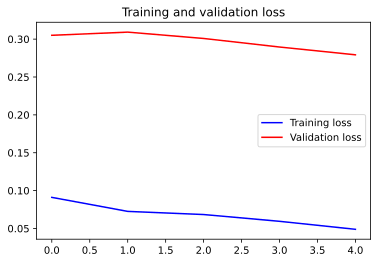

In [127]:
md_xception.compile(trainable_frac=0.5, lr=1e-4)
md_xception.train_and_test(desc='xp_t50', n_epochs=5)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
Total params: 21,917,746
Trainable params: 20,707,770
Non-trainable params: 1,209,976
_________________________________

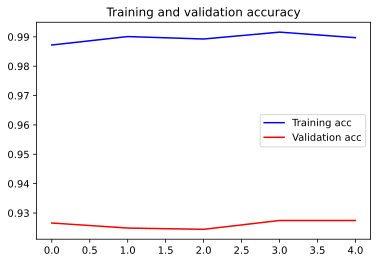

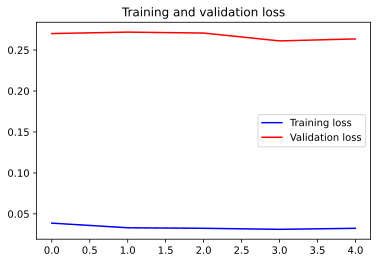

In [128]:
md_xception.compile(trainable_frac=0.75, lr=1e-5)
md_xception.train_and_test(desc='xp_t75', n_epochs=5)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
Total params: 21,917,746
Trainable params: 21,807,666
Non-trainable params: 110,080
___________________________________

/opt/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
1654/1654 [==============================] - 615s 372ms/step - loss: 0.0503 - accuracy: 0.9849 - val_loss: 0.2740 - val_accuracy: 0.9279

Epoch 00002: saving model to ./best_model_xp_t100.hdf5
Epoch 3/5
1654/1654 [==============================] - 615s 372ms/step - loss: 0.0518 - accuracy: 0.9829 - val_loss: 0.2678 - val_accuracy: 0.9304

Epoch 00003: saving model to ./best_model_xp_t100.hdf5
Epoch 4/5
1654/1654 [==============================] - 615s 372ms/step - loss: 0.0479 - accuracy: 0.9845 - val_loss: 0.2683 - val_accuracy: 0.9309

Epoch 00004: saving model to ./best_model_xp_t100.hdf5
Epoch 5/5
1654/1654 [==============================] - 615s 371ms/step - loss: 0.0424 - accuracy: 0.9856 - val_loss: 0.2657 - val_accuracy: 0.9326

Epoch 00005: saving model to ./best_model_xp_t100.hdf5
292/292 [==============================] - 21s 73ms/step - loss: 0.2657 - accuracy: 0.9326
Test accuracy: 93.26%


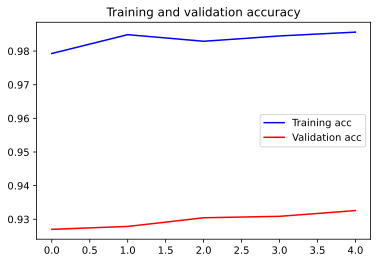

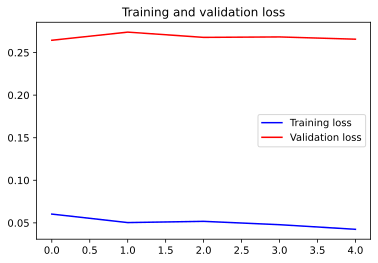

In [130]:
md_xception.compile(trainable_frac=1, lr=1e-5)
md_xception.train_and_test(desc='xp_t100', n_epochs=5, batch_size=int(BATCH_SIZE/2))

In [131]:
md_xception.make_submission(desc='xp_t100')

Found 6675 validated image filenames.
418/418 [==============================] - 56s 134ms/step
Save submit


In [132]:
!kaggle competitions submit -c sf-dl-car-classification -f submission_xp_t100.csv -m "xception fine tuning 100%"

100%|██████████████████████████████████████| 78.7k/78.7k [00:04<00:00, 17.1kB/s]
Successfully submitted to [SF] Car classification

рейтиг для данного сабмишна **0.92644**, что немного ниже, чем при первоначальной поптыке обучить нейросеть с нуля. модель переобучилась, но что было сделано не так - непонятно.

## Выбор более мощной модели

Как известно, на базе `ImageNet` натренировано (и продолжают тренироваться) множество СНН, есть даже специализированный [рейтинг](https://paperswithcode.com/sota/image-classification-on-imagenet?dimension=Top%205%20Accuracy)
![рейтинг](./imagenet_cnn_rating.png)

Из всех доступных на сегодня СНС я выбрал для пробы **ResNet50V2** и **EfficientNet-B7** по нескольким причинам:
1. высокий рейтинг
2. относительно небольшое количество параметров ("всего" 60+ миллионов)
3. имплементация на `tensorflow`

На следующем этапе попробуем дообучить под задачу проекта нейросеть **ResNet50V2**

## ResNet50V2: обучение модели целиком

In [50]:
from tensorflow.keras.applications import ResNet50V2

In [80]:
bm_resnet = ResNet50V2(weights='imagenet', include_top=False, input_tensor=None)
bm_resnet.summary()

94683136/94668760 [==============================] - 17s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_______________________

__________________________________________________________________________________________________
conv5_block2_2_pad (ZeroPadding (None, None, None, 5 0           conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, None, None, 5 2359296     conv5_block2_2_pad[0][0]         
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, None, None, 5 2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, None, None, 5 0           conv5_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_3_conv (Conv2D)    (None, None, None, 2 1050624     conv5_block2_2_relu[0][0]        
__________

In [81]:
md_resnet = ModelSet(bm_resnet)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


Модель `md_resnet` обучалась целиком в течение 20 эпох с `learning_rate=1e-3`, а затем еще в течение 5 эпох с `learning_rate=1e-4`. по результатам веса модели были сохранены в файл `best_model_rn_from_scratch_v2.hdf5`, был сделан сабмишн.

In [82]:
md_resnet.compile(lr=1e-3)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_23 (Batc (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                5130      
Total params: 24,621,066
Trainable params: 24,574,602
Non-trainable params: 46,464
_____________________________________

Epoch 1/20
827/827 [==============================] - 309s 364ms/step - loss: 1.2123 - accuracy: 0.5811 - val_loss: 1.2326 - val_accuracy: 0.6067

Epoch 00001: saving model to ./best_model_rn_from_scratch.hdf5


/opt/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
827/827 [==============================] - 300s 363ms/step - loss: 0.5575 - accuracy: 0.8018 - val_loss: 0.5211 - val_accuracy: 0.8179

Epoch 00002: saving model to ./best_model_rn_from_scratch.hdf5
Epoch 3/20
827/827 [==============================] - 301s 363ms/step - loss: 0.4220 - accuracy: 0.8547 - val_loss: 0.4888 - val_accuracy: 0.8270

Epoch 00003: saving model to ./best_model_rn_from_scratch.hdf5
Epoch 4/20
827/827 [==============================] - 301s 364ms/step - loss: 0.3359 - accuracy: 0.8819 - val_loss: 0.2990 - val_accuracy: 0.8939

Epoch 00004: saving model to ./best_model_rn_from_scratch.hdf5
Epoch 5/20
827/827 [==============================] - 300s 363ms/step - loss: 0.2916 - accuracy: 0.8968 - val_loss: 0.2757 - val_accuracy: 0.9017

Epoch 00005: saving model to ./best_model_rn_from_scratch.hdf5
Epoch 6/20
827/827 [==============================] - 300s 363ms/step - loss: 0.2462 - accuracy: 0.9133 - val_loss: 0.3408 - val_accuracy: 0.8935

Epoch 00006: 

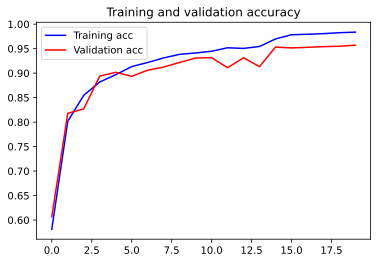

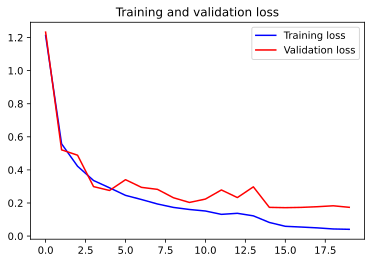

In [83]:
md_resnet.train_and_test(desc='rn_from_scratch', n_epochs=20)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_23 (Batc (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                5130      
Total params: 24,621,066
Trainable params: 24,574,602
Non-trainable params: 46,464
_____________________________________

/opt/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
827/827 [==============================] - 300s 363ms/step - loss: 0.0341 - accuracy: 0.9868 - val_loss: 0.1815 - val_accuracy: 0.9545

Epoch 00002: saving model to ./best_model_rn_from_scratch_v2.hdf5
Epoch 3/5
827/827 [==============================] - 300s 363ms/step - loss: 0.0371 - accuracy: 0.9859 - val_loss: 0.1752 - val_accuracy: 0.9575

Epoch 00003: saving model to ./best_model_rn_from_scratch_v2.hdf5
Epoch 4/5
827/827 [==============================] - 300s 363ms/step - loss: 0.0304 - accuracy: 0.9892 - val_loss: 0.1824 - val_accuracy: 0.9545

Epoch 00004: saving model to ./best_model_rn_from_scratch_v2.hdf5
Epoch 5/5
827/827 [==============================] - 301s 364ms/step - loss: 0.0287 - accuracy: 0.9896 - val_loss: 0.1806 - val_accuracy: 0.9566

Epoch 00005: saving model to ./best_model_rn_from_scratch_v2.hdf5
146/146 [==============================] - 14s 98ms/step - loss: 0.1806 - accuracy: 0.9566
Test accuracy: 95.66%


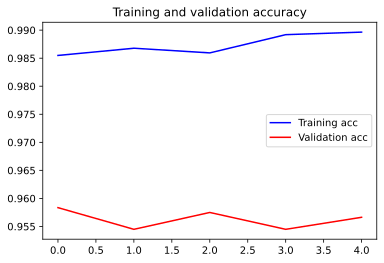

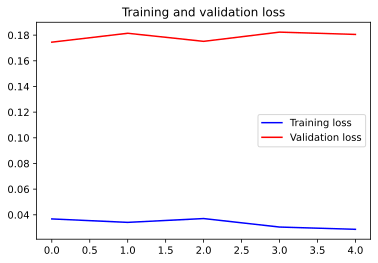

In [84]:
md_resnet.compile(lr=1e-4)
md_resnet.train_and_test(desc='rn_from_scratch_v2', n_epochs=5)

In [85]:
md_resnet.make_submission(desc='rn_from_scratch_v2')

Found 6675 validated image filenames.
418/418 [==============================] - 41s 97ms/step
Save submit


In [86]:
!kaggle competitions submit -c sf-dl-car-classification -f submission_rn_from_scratch_v2.csv -m "resnet from scratch v2"

100%|██████████████████████████████████████| 78.7k/78.7k [00:04<00:00, 17.9kB/s]
Successfully submitted to [SF] Car classification

результат **ResNet50V2** в `kaggle` составил **0.95505**.

## EfficientNetB7: обучение модели целиком

In [16]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [90]:
bm_effnet7 = EfficientNetB7(weights='imagenet', include_top=False, input_tensor=None, input_shape=input_shape)

In [91]:
md_effnet7 = ModelSet(bm_effnet7, rescale=False)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [ ]:
# md_effnet7d.compile(lr=1e-3)
# md_effnet7d.train_and_test(decs='en_from_scratch', n_epochs=20, batch_size=4)
# md_effnet7d.compile(lr=1e-4)
# md_effnet7d.train_and_test(decs='en_from_scratch_v2', n_epochs=5, batch_size=4)

Модель `md_effnet7` обучалась целиком на более мощной машине в течение 20 эпох с `learning_rate=1e-3`, а затем еще в течение 5 эпох с `learning_rate=1e-4`. по результатам веса модели были сохранены в файл `best_model_en_from_scratch_v2.hdf5`, загружены тут и был сделан сабмишн.

In [95]:
md_effnet7.load_weights('en_from_scratch_v2')
md_effnet7.compile()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2560)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               1311232   
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               2048      
_________________________________________________________________
dense_17 (Dense)             (None, 10)                5130      
Total params: 65,416,097
Trainable params: 65,104,346
Non-trainable params: 311,751
_________________________________________________________________


In [96]:
md_effnet7.make_submission(desc='en_from_scratch_v2')

Found 6675 validated image filenames.
418/418 [==============================] - 182s 426ms/step
Save submit


In [97]:
!kaggle competitions submit -c sf-dl-car-classification -f submission_en_from_scratch_v2.csv -m "effnet7 from scratch"

100%|██████████████████████████████████████| 78.7k/78.7k [00:04<00:00, 18.3kB/s]
Successfully submitted to [SF] Car classification

score=**0.96764** (0.9648 val_accuracy)

## EfficientNetB7 fine tuning

Создадим заново модель на основе EfficientNetB7, но на этот раз заморозим ее, обучим "голову", а затем в несколько приемов дообучим всю сеть, постепенно размораживая слои базовой модели

In [22]:
bm_effnet7 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
md_effnet7 = ModelSet(bm_effnet7, rescale=False)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


В описании к `EfficientNetB7` сказано, что разморажиать сеть лучше всего блоками. Если посмотреть в `bm_effnet7.summary()`, то станет понятно, что блоки можно отследить по наваниям слоев. В коде ниже блоки группируются по номерам слоев, где каждая строка представляет собой tupple из 3 значений:
* номер слоя начала блока
* номер слоя начала следующего блока (iterator-like)
* название блока

В дальнейшем будем размораживать базовую сеть в соответствие с этими блоками

Также в описании к `EfficientNetB7` написано, что при замороженной базовой сети `learning_rate` надо взять `1e-2`

In [23]:
b7_names = list([layer.name.split('_')[0] for layer in bm_effnet7.layers])
b7_blocks = list()
prev_name = ''
prev_idx = 0
idx = 0
for name in b7_names:
    name = name[:-1] if name[:5] == 'block' else name
    if name != prev_name and idx > 0:
        b7_blocks.append((prev_idx, idx, name)) # [prev_idx, idx)
        prev_name = name
        prev_idx = idx
    
    idx += 1
    
b7_blocks

[(0, 1, 'rescaling'),
 (1, 2, 'normalization'),
 (2, 3, 'stem'),
 (3, 7, 'block1'),
 (7, 53, 'block2'),
 (53, 157, 'block3'),
 (157, 261, 'block4'),
 (261, 410, 'block5'),
 (410, 558, 'block6'),
 (558, 752, 'block7'),
 (752, 810, 'top')]

In [24]:
md_effnet7.compile(trainable_frac=0, lr=1e-2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 65,416,097
Trainable params: 1,317,386
Non-trainable params: 64,098,711
_________________________________________________________________


Epoch 1/10
827/827 [==============================] - 443s 523ms/step - loss: 1.2955 - accuracy: 0.5579 - val_loss: 0.9325 - val_accuracy: 0.6771

Epoch 00001: saving model to ./best_model_en_t0.hdf5


/opt/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
827/827 [==============================] - 429s 519ms/step - loss: 0.9818 - accuracy: 0.6508 - val_loss: 0.8022 - val_accuracy: 0.7162

Epoch 00002: saving model to ./best_model_en_t0.hdf5
Epoch 3/10
827/827 [==============================] - 431s 521ms/step - loss: 0.8657 - accuracy: 0.6889 - val_loss: 0.8842 - val_accuracy: 0.6818

Epoch 00003: saving model to ./best_model_en_t0.hdf5
Epoch 4/10
827/827 [==============================] - 430s 520ms/step - loss: 0.7960 - accuracy: 0.7190 - val_loss: 0.7736 - val_accuracy: 0.7334

Epoch 00004: saving model to ./best_model_en_t0.hdf5
Epoch 5/10
827/827 [==============================] - 430s 520ms/step - loss: 0.7357 - accuracy: 0.7412 - val_loss: 0.7205 - val_accuracy: 0.7574

Epoch 00005: saving model to ./best_model_en_t0.hdf5
Epoch 6/10
827/827 [==============================] - 430s 520ms/step - loss: 0.6984 - accuracy: 0.7525 - val_loss: 0.6548 - val_accuracy: 0.7630

Epoch 00006: saving model to ./best_model_en_t0.hdf5


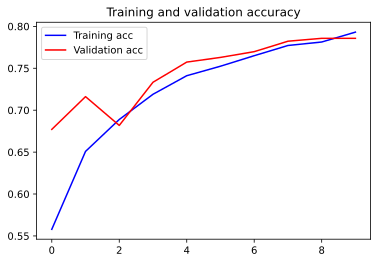

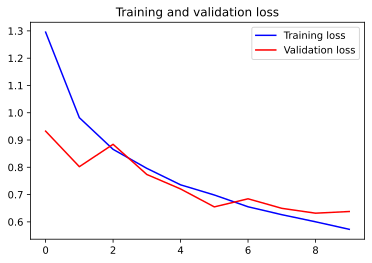

In [25]:
md_effnet7.train_and_test(desc='en_t0')

In [26]:
md_effnet7.compile(trainable_since=b7_blocks[-1][0], lr=1e-2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 65,416,097
Trainable params: 24,393,802
Non-trainable params: 41,022,295
_________________________________________________________________


Epoch 1/10
827/827 [==============================] - 526s 625ms/step - loss: 0.9516 - accuracy: 0.6872 - val_loss: 0.6349 - val_accuracy: 0.8094

Epoch 00001: saving model to ./best_model_en_t1.hdf5
Epoch 2/10
827/827 [==============================] - 514s 621ms/step - loss: 0.4263 - accuracy: 0.8513 - val_loss: 0.3404 - val_accuracy: 0.8888

Epoch 00002: saving model to ./best_model_en_t1.hdf5
Epoch 3/10
827/827 [==============================] - 514s 622ms/step - loss: 0.3115 - accuracy: 0.8893 - val_loss: 0.2964 - val_accuracy: 0.8987

Epoch 00003: saving model to ./best_model_en_t1.hdf5
Epoch 4/10
827/827 [==============================] - 514s 621ms/step - loss: 0.2585 - accuracy: 0.9059 - val_loss: 0.2898 - val_accuracy: 0.9038

Epoch 00004: saving model to ./best_model_en_t1.hdf5
Epoch 5/10
827/827 [==============================] - 514s 621ms/step - loss: 0.2164 - accuracy: 0.9232 - val_loss: 0.2732 - val_accuracy: 0.9154

Epoch 00005: saving model to ./best_model_en_t1.hdf5


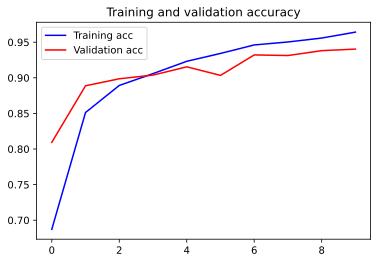

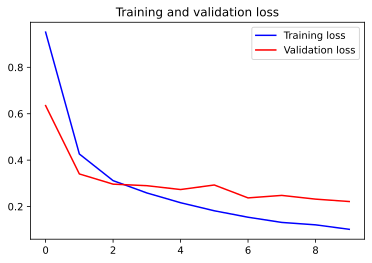

In [27]:
md_effnet7.train_and_test(desc='en_t1')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 65,416,097
Trainable params: 52,784,514
Non-trainable params: 12,631,583
_________________________________________________________________
Epoch 1/10
827/827 [==============================] - 682s 812ms/step - loss: 0.2080 - accuracy: 0.

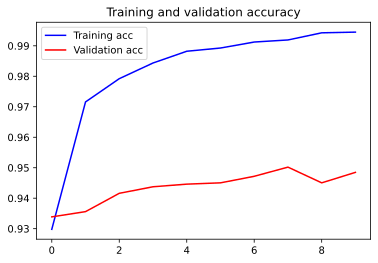

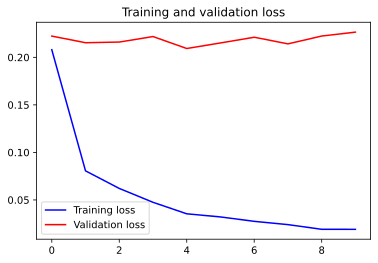

In [28]:
md_effnet7.compile(trainable_since=b7_blocks[-2][0], lr=1e-3)
md_effnet7.train_and_test(desc='en_t2')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 65,416,097
Trainable params: 60,400,418
Non-trainable params: 5,015,679
_________________________________________________________________
Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Epoch 1/10
33

/opt/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
3308/3308 [==============================] - 1181s 357ms/step - loss: 0.2229 - accuracy: 0.9406 - val_loss: 0.2747 - val_accuracy: 0.9472

Epoch 00002: saving model to ./best_model_en_t3.hdf5
Epoch 3/10
3308/3308 [==============================] - 1183s 358ms/step - loss: 0.1852 - accuracy: 0.9500 - val_loss: 0.2619 - val_accuracy: 0.9506

Epoch 00003: saving model to ./best_model_en_t3.hdf5
Epoch 4/10
3308/3308 [==============================] - 1183s 358ms/step - loss: 0.1759 - accuracy: 0.9523 - val_loss: 0.2636 - val_accuracy: 0.9480

Epoch 00004: saving model to ./best_model_en_t3.hdf5
Epoch 5/10
3308/3308 [==============================] - 1184s 358ms/step - loss: 0.1678 - accuracy: 0.9550 - val_loss: 0.2637 - val_accuracy: 0.9502

Epoch 00005: saving model to ./best_model_en_t3.hdf5
Epoch 6/10
3308/3308 [==============================] - 1184s 358ms/step - loss: 0.1431 - accuracy: 0.9615 - val_loss: 0.2646 - val_accuracy: 0.9519

Epoch 00006: saving model to ./best_mo

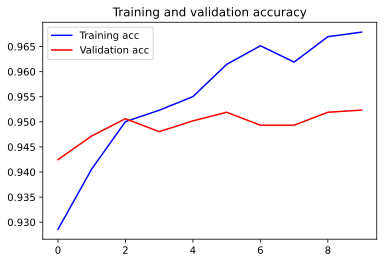

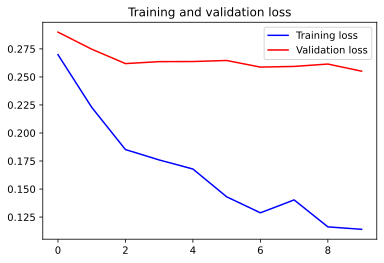

In [35]:
md_effnet7.compile(trainable_since=b7_blocks[-3][0], lr=1e-4)
md_effnet7.train_and_test(desc='en_t3', batch_size=int(BATCH_SIZE/4))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 65,416,097
Trainable params: 64,122,078
Non-trainable params: 1,294,019
_________________________________________________________________
Epoch 1/5
3308/3308 [==============================] - 1340s 401ms/step - loss: 0.1503 - accuracy: 0

/opt/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
3308/3308 [==============================] - 1329s 402ms/step - loss: 0.1210 - accuracy: 0.9667 - val_loss: 0.2637 - val_accuracy: 0.9468

Epoch 00002: saving model to ./best_model_en_t4.hdf5
Epoch 3/5
3308/3308 [==============================] - 1328s 402ms/step - loss: 0.1146 - accuracy: 0.9668 - val_loss: 0.2575 - val_accuracy: 0.9489

Epoch 00003: saving model to ./best_model_en_t4.hdf5
Epoch 4/5
3308/3308 [==============================] - 1329s 402ms/step - loss: 0.1092 - accuracy: 0.9686 - val_loss: 0.2679 - val_accuracy: 0.9459

Epoch 00004: saving model to ./best_model_en_t4.hdf5
Epoch 5/5
3308/3308 [==============================] - 1329s 402ms/step - loss: 0.0938 - accuracy: 0.9736 - val_loss: 0.2540 - val_accuracy: 0.9485

Epoch 00005: saving model to ./best_model_en_t4.hdf5
583/583 [==============================] - 76s 131ms/step - loss: 0.2540 - accuracy: 0.9485
Test accuracy: 94.85%


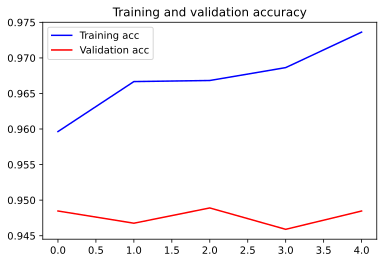

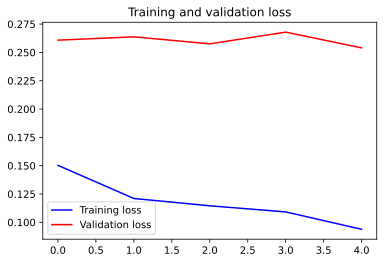

In [37]:
md_effnet7.compile(trainable_since=b7_blocks[-4][0], lr=1e-4)
md_effnet7.train_and_test(desc='en_t4', n_epochs=5, batch_size=int(BATCH_SIZE/4))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 65,416,097
Trainable params: 65,104,346
Non-trainable params: 311,751
_________________________________________________________________
Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Epoch 1/5
6616/

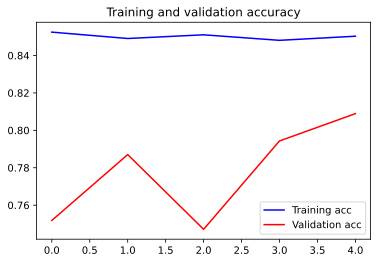

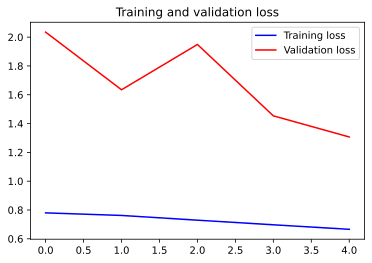

In [41]:
md_effnet7.compile(trainable_since=0, lr=1e-4)
md_effnet7.train_and_test(desc='en_t5', n_epochs=5, batch_size=int(BATCH_SIZE/8))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 65,416,097
Trainable params: 65,104,346
Non-trainable params: 311,751
_________________________________________________________________
Epoch 1/5
6616/6616 [==============================] - 2747s 413ms/step - loss: 0.6678 - accuracy: 0.8

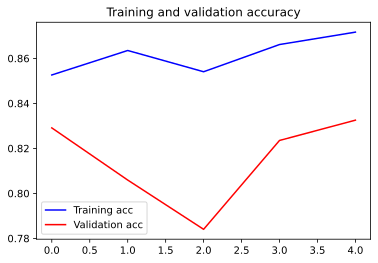

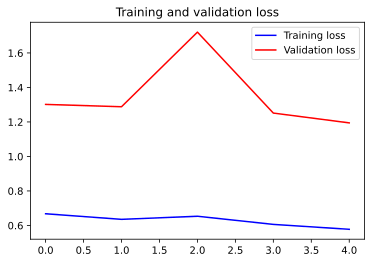

In [43]:
md_effnet7.compile(trainable_since=0, lr=1e-4)
md_effnet7.train_and_test(desc='en_t6', n_epochs=5, batch_size=int(BATCH_SIZE/8))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 65,416,097
Trainable params: 65,104,346
Non-trainable params: 311,751
_________________________________________________________________
Epoch 1/3
6616/6616 [==============================] - 2741s 412ms/step - loss: 0.6122 - accuracy: 0.8

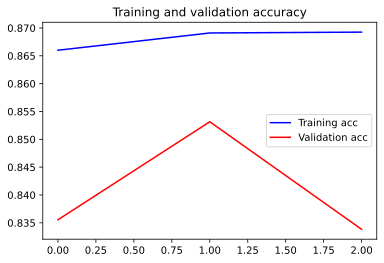

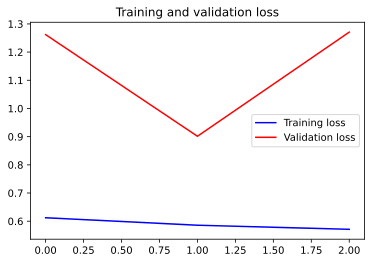

In [44]:
md_effnet7.compile(trainable_since=0, lr=1e-5)
md_effnet7.train_and_test(desc='en_t7', n_epochs=3, batch_size=int(BATCH_SIZE/8))

## EfficientNetB7 с регуляризацией

на этот раз в голову модели добавили регуляризацию: `Dropout(0.25)` и обучили модель целиком

In [32]:
bm_effnet7d = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
md_effnet7d = ModelSet(bm_effnet7d, drop_rate=0.25, rescale=False)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [30]:
md_effnet7d.compile(lr=1e-3)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2560)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1311232   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 65,416,097
Trainable params: 65,104,346
Non-trainable params: 311,751
____________________________________

In [ ]:
md_effnet7d.train_and_test(desc='en_d_from_scratch', n_epochs=20, batch_size=2)
md_effnet7d.compile(lr=1e-4)
md_effnet7d.train_and_test(desc='en_d_from_scratch_v2', n_epochs=5, batch_size=2)

Модель так же обучалась на более мощной машине. 

Test accuracy = 96.39%

Kaggle score = **0.96644**

## TTA

следующий ниже метод `make_tta_submission` получает инстанс класса `ModelSet`, делает 10 предсказаний с истользованием TTA, а затем усредняет их, и на основе усредненных показаний делает сабмишн. Промежуточным итогом рисуется график предсказаний по попыткам для первых 50 картинок

In [71]:
subm_tta_datagen = ImageDataGenerator(
    #rescale=1/255,
    # ниже параметры аугментаций:
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2)
)

subm_generator = subm_tta_datagen.flow_from_dataframe(
        dataframe=sample_submission,
        directory=PATH+'test_upload/',
        x_col="Id",
        y_col=None,
        shuffle=False,
        class_mode=None,
        seed=RANDOM_SEED,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

def make_tta_submission(md_set, count=10, desc=None):
    filename = 'submission.csv' if desc == None else ('submission_' + str(desc) +'.csv')
    filename = MODEL_PATH + filename
    all_predictions = []
    for i in range(count):
        pred = md_set.model.predict(subm_generator, steps=len(subm_generator), verbose=1) 
        all_predictions.append(pred)
        subm_generator.reset()

    #return np.array(all_predictions)
    all_predictions = np.array(all_predictions)
    plt.figure(figsize=(15, 3))
    plt.imshow(all_predictions.argmax(axis=-1)[:, :50], cmap='nipy_spectral')
    plt.xlabel('Номер изображения')
    plt.ylabel('Номер попытки')
    plt.show()

    final_predictions = all_predictions.mean(axis=0).argmax(axis=-1)
    label_map = (md_set.train_generator.class_indices)
    label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
    final_predictions = [label_map[k] for k in final_predictions]
    filenames_with_dir=subm_generator.filenames
    submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':final_predictions}, columns=['Id', 'Category'])
    submission['Id'] = submission['Id'].replace('test_upload/','')
    submission.to_csv(filename, index=False)
    print('Save submit')
    submission.head()

Found 6675 validated image filenames.


прогоним ТТА на лучшей версии `EfficientNetB7`

In [46]:
bm_effnet7 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
md_effnet7 = ModelSet(bm_effnet7, rescale=False)
md_effnet7.load_weights(desc='en_from_scratch_v2')
md_effnet7.compile()

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2560)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1311232   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 65,416,097
Trainable params: 65,104,346
Non-trainable params: 311,751
_________________________________________________________________


Found 6675 validated image filenames.
418/418 [==============================] - 178s 426ms/step


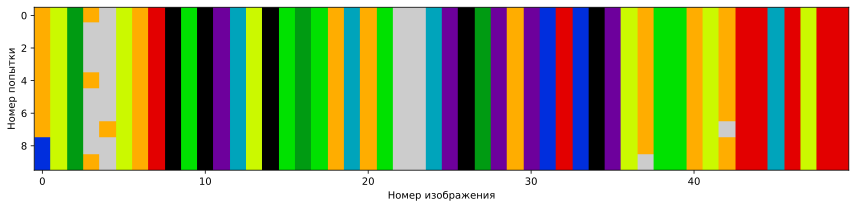

Save submit


In [47]:
make_tta_submission(md_effnet7, desc='tta_en')

In [48]:
!kaggle competitions submit -c sf-dl-car-classification -f submission_tta_en.csv -m "TTA on best effnet"

100%|██████████████████████████████████████| 78.7k/78.7k [00:02<00:00, 35.1kB/s]
Successfully submitted to [SF] Car classification

score **0.96704**

## Ансамблирование

На первом подходе ассамблирования сделаем по 10 предсказаний с ТТА (как на предыдущем шаге) для 3 обученных моделей (`Xception`, `ResNet50V2` и `EfficientNetB7`), для каждой модели возьмем среднее предсказание (усредняем вероятности), а потом возьмем взвешанное среднее для всех трех моделей. Весами будут полученные на предыдущих шагах рейтинги этих моделей на `kaggle.com`

In [79]:
def make_tta_submission_multi(md_list, count=10):
    all_predictions = []
    for md_set in md_list:
        md_predictions = []
        for i in range(count):
            pred = md_set.model.predict(subm_generator, steps=len(subm_generator), verbose=1) 
            md_predictions.append(pred)
            subm_generator.reset()
            
        md_predictions = np.array(md_predictions)
        all_predictions.append(md_predictions.mean(axis=0))

    return np.array(all_predictions)

In [51]:
bm_resnet = ResNet50V2(weights='imagenet', include_top=False, input_tensor=None)
md_resnet = ModelSet(bm_resnet)
md_resnet.load_weights(desc='rn_from_scratch_v2')
md_resnet.compile()

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 24,621,066
Trainabl

In [53]:
bm_xception = Xception(weights='imagenet', include_top=False, input_tensor=None)
md_xception = ModelSet(bm_xception)
md_xception.load_weights(desc='xp_from_scratch_v2')
md_xception.compile()

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_15 (Batc (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                5130      
Total params: 21,917,746
Trainabl

In [54]:
md_list = [md_effnet7, md_resnet, md_xception]
md_coef = [0.96764, 0.95505, 0.94831]

In [57]:
all_pred = make_tta_submission_multi(md_list, desc='tta_multi')

Found 6675 validated image filenames.
418/418 [==============================] - 64s 152ms/step


In [61]:
md_coef = md_coef / np.sum(md_coef)
md_coef

array([0.33703936, 0.33265413, 0.33030651])

In [73]:
final_predictions = (all_pred[0] * md_coef[0]) \
    + (all_pred[1] * md_coef[1]) \
    + (all_pred[1] * md_coef[1])

In [74]:
final_predictions = final_predictions.argmax(axis=-1)
label_map = (md_effnet7.train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
final_predictions = [label_map[k] for k in final_predictions]
filenames_with_dir=subm_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':final_predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(MODEL_PATH + 'submission_tta_multi.csv', index=False)
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


In [75]:
!kaggle competitions submit -c sf-dl-car-classification -f submission_tta_multi.csv -m "TTA on best effnet+resnet+xception"

100%|██████████████████████████████████████| 78.7k/78.7k [00:02<00:00, 31.2kB/s]
Successfully submitted to [SF] Car classification

Полученный score **0.96704**, результат не стал лучше

Теперь попробуем сделать предсказание методом голосования. Для каждой модели сделаем по 10 предсказаний с ТТА, для каждого из 30 предсказаний выберем класс с максимальной вероятностью, а затем выберем тот класс, которого среди этих предсказаний получилось больше всего (т.е. за который модели чаще голосуют)

In [83]:
def make_tta_submission_multi2(md_list, count=10):
    all_predictions = []
    for md_set in md_list:
        for i in range(count):
            pred = md_set.model.predict(subm_generator, steps=len(subm_generator), verbose=1) 
            subm_generator.reset()
            
        all_predictions.append(pred)

    return np.array(all_predictions)

In [81]:
all_predictions2 = make_tta_submission_multi2(md_list)

418/418 [==============================] - 64s 153ms/step


In [86]:
all_predictions2.shape

(30, 6675, 10)

In [87]:
all_predictions2x = all_predictions2.argmax(axis=-1)

In [89]:
all_predictions2x.shape

(30, 6675)

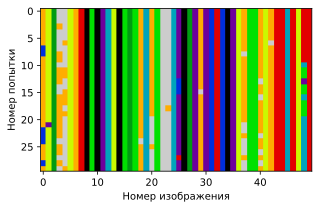

In [100]:
plt.figure(figsize=(15, 3))
plt.imshow(all_predictions2x[:, :50], cmap='nipy_spectral')
plt.xlabel('Номер изображения')
plt.ylabel('Номер попытки')
plt.show()

In [111]:
n_pred = all_predictions2x.shape[1]
final_prediction2x = np.empty(n_pred)
for i in range(n_pred):
    x = np.bincount(all_predictions2x[:, i]).argmax()
    final_prediction2x[i] = x

In [114]:
final_prediction2x

array([7., 6., 4., ..., 1., 3., 4.])

In [116]:
label_map = (md_effnet7.train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
final_prediction2x = [label_map[k] for k in final_prediction2x]
filenames_with_dir=subm_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':final_predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(MODEL_PATH + 'submission_tta_multi_v2.csv', index=False)
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


In [117]:
!kaggle competitions submit -c sf-dl-car-classification -f submission_tta_multi_v2.csv -m "TTA on best effnet+resnet+xception v2"

100%|██████████████████████████████████████| 78.7k/78.7k [00:01<00:00, 48.5kB/s]
Successfully submitted to [SF] Car classification

score **0.96704**, изменение логики результата не дало.

## Стеккинг

На этом шаге я рассчитывал для каждой из моделей сделать предсказания классов для каждой из 3 моделей (`Xception`, `ResNet50V2`, `EfficientNetB7`), объединить их в `pandas.DataFrame` и обучить на нем `RandomForestClassifier` из пакета `sklearn`.
Но как-нибудь в другой раз.

## Выводы

Если бы целью работы было "захотеть бросить DL навсегда", то хотя бы ее можно было бы считать достигнутой. Времени на проект было потрачено слишком много, но, как говорится, тяжело в учении - легко в бою.

На выходе из проекта у меня больше вопросов, чем ответов. Например:
* почему fine tuning с постепенной разморозкой базовой модели стабильно показывает результат хуже, чем обучение модели целиком?
* почему не помогает ТТА?
* почему регуляризация не дает прирост качества?
* как подбирать learning rate при fine tuning?
* почему не работают приемы, описанные в инструкции к EfficientNet? в частности:
* почему разморозка EfficientNet блоками не дает значимого улучшения качества модели по сравнению с разморозкой случайными пачками слоев?
* почему запрет разморозки слоев BatchNormalization на порядки ухудшает результат обучения, хотя в документации несколько раз подчеркивается, что при fine tuning сети EfficientNet слои BatchNormalization должны быть замороженными?

В сухом остатке, конечно же останется навык работы с `tensorflow` и `keras`, а также желание купить себе какой-нибудь мощный GPU для дальнейших экспериментов с DL